In [49]:
import pandas as pd
import numpy as np
import re
import operator
from sklearn.model_selection import cross_validate, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("bmh")
plt.rc('font', family='SimHei', size=13)

In [2]:
data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/test.csv')
df = data_train.append(data_test)

/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
df[df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [4]:
df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
116,70.5,NaN,Q,7.7500,"Connors, Mr. Patrick",0,117,3,male,0,0.0,370369
280,65.0,NaN,Q,7.7500,"Duane, Mr. Frank",0,281,3,male,0,0.0,336439
326,61.0,NaN,S,6.2375,"Nysveen, Mr. Johan Hansen",0,327,3,male,0,0.0,345364
851,74.0,NaN,S,7.7750,"Svensson, Mr. Johan",0,852,3,male,0,0.0,347060
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [5]:
# 提取出Name中的Surname信息
df['surname'] = df["Name"].apply(lambda x: x.split(',')[0].lower())
fare_mean_estimated = df.loc[(df['Pclass']==3)&(df['Age']>60)&(df['Sex']=='male')].Fare.mean()
df.loc[df['surname']=='storey','Fare'] = fare_mean_estimated

In [6]:
# Embarked缺失值处理
df[df['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,surname
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,icard
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,stone


In [7]:
df['Embarked'] = df['Embarked'].fillna('C')

In [10]:
df['CabinCat'] = pd.Categorical(df.Cabin.fillna('0').apply(lambda x: x[0])).codes

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


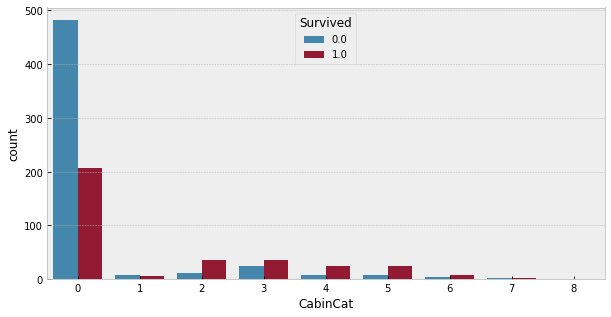

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='CabinCat', hue='Survived',data=df)
plt.show()

In [15]:
df.loc[df['surname']=='abbott',['Name','Sex','Age','SibSp','Parch']]

,Name,Sex,Age,SibSp,Parch
279,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1
746,"Abbott, Mr. Rossmore Edward",male,16.0,1,1
392,"Abbott, Master. Eugene Joseph",male,13.0,0,2


In [16]:
df.loc[(df['surname']=='abbott')&(df['Age']==35),'SibSp'] = 0
df.loc[(df['surname']=='abbott')&(df['Age']==35),'Parch'] = 2
df.loc[(df['surname']=='abbott')&(df['Age']==13),'SibSp'] = 1
df.loc[(df['surname']=='abbott')&(df['Age']==13),'Parch'] = 1

In [17]:
df.loc[df['surname']=='ford',['Name','Sex','Age','SibSp','Parch']]

,Name,Sex,Age,SibSp,Parch
86,"Ford, Mr. William Neal",male,16.0,1,3
147,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2
436,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2
736,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3
167,"Ford, Mr. Edward Watson",male,18.0,2,2
289,"Ford, Mr. Arthur",male,NaN,0,0


In [18]:
df.loc[(df['surname']=='ford')&(df['Age']==16),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==16),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==9),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==9),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==21),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==21),'Parch'] = 1
df.loc[(df['surname']=='ford')&(df['Age']==48),'SibSp'] = 0
df.loc[(df['surname']=='ford')&(df['Age']==48),'Parch'] = 4
df.loc[(df['surname']=='ford')&(df['Age']==18),'SibSp'] = 3
df.loc[(df['surname']=='ford')&(df['Age']==18),'Parch'] = 1

In [23]:
# 从Name中提取Title信息，因为同为男性，Mr.和 Master.的生还率是不一样的
df["Title"] = df["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

# 量化Title信息
df["TitleCat"] = df.loc[:,'Title'].map(title_mapping)

# SibSp和Parch特征进行组合
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
# 根据FamilySize分布进行分箱
df["FamilySize"] = pd.cut(df["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

# 从Name特征衍生出Name的长度
df["NameLength"] = df["Name"].apply(lambda x: len(x))

# 量化Embarked特征
df["Embarked"] = pd.Categorical(df.Embarked).codes

# 对Sex特征进行独热编码分组
df = pd.concat([df,pd.get_dummies(df['Sex'])],axis=1)

In [25]:
# 妇女/儿童 男士标签
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'

df = pd.concat([df, pd.DataFrame(df[['Age', 'Sex']].apply(get_person, axis=1), columns=['person'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['person'])],axis=1)
# get_dummies方法可以对一个有限类型的列拆分成多个列并one_hot编码

In [28]:
table_ticket = pd.DataFrame(df["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Numbers'}, inplace=True)
table_ticket['Ticket_dead_women'] = df.Ticket[(df.female_adult == 1.0) 
                                    & (df.Survived == 0.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()

table_ticket['Ticket_dead_women'] = table_ticket['Ticket_dead_women'].fillna(0)
table_ticket['Ticket_dead_women'][table_ticket['Ticket_dead_women'] > 0] = 1.0

table_ticket['Ticket_surviving_men'] = df.Ticket[(df.male_adult == 1.0) 
                                    & (df.Survived == 1.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()

table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

# Ticket特征量化
table_ticket["Ticket_Id"] = pd.Categorical(table_ticket.index).codes

table_ticket["Ticket_Id"][table_ticket["Ticket_Numbers"] < 3 ] = -1
# Ticket数量分箱
table_ticket["Ticket_Numbers"] = pd.cut(table_ticket["Ticket_Numbers"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_ticket, left_on="Ticket",right_index=True, how='left', sort=False)

/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
table_surname = pd.DataFrame(df["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = df.surname[(df.female_adult == 1.0) 
                                    & (df.Survived == 0.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = df.surname[(df.male_adult == 1.0) 
                                    & (df.Survived == 1.0) 
                                    & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

df = pd.merge(df, table_surname, left_on="surname",right_index=True,how='left', sort=False)

/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
            'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Numbers','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200,random_state=0)
X_train = df[classers][df['Age'].notnull()]
Y_train = df['Age'][df['Age'].notnull()]
X_test = df[classers][df['Age'].isnull()]

etr.fit(X_train.as_matrix(),np.ravel(Y_train))
age_preds = etr.predict(X_test.as_matrix())
df['Age'][df['Age'].isnull()] = age_preds

/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/Users/sjtc/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


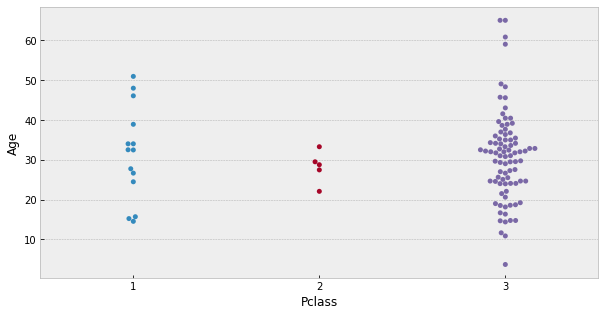

In [33]:
# Age缺失值填补后的情况
X_test['Age'] = pd.Series(age_preds)
f,ax=plt.subplots(figsize=(10,5))
sns.swarmplot(x='Pclass',y='Age',data=X_test)
plt.show()

In [37]:
def get_type_cabine(cabine):
    # Use a regular expression to search for a title. 
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'
df['Cabin'] = df['Cabin'].fillna(' ')
df['CabinType'] = df['Cabin'].apply(get_type_cabine)

In [38]:
target = data_train["Survived"].values
features= ['female','male','Age','male_adult','female_adult', 'child','TitleCat',
           'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
           'Fare','Embarked','Surname_Members','Ticket_Numbers','FamilySize',
           'Ticket_dead_women','Ticket_surviving_men',
           'Surname_perishing_women','Surname_surviving_men']

train = df[0:891].copy()
test = df[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_dead_women
13.04 Surname_surviving_men
10.36 Surname_perishing_women
6.78 Embarked
5.27 Ticket_Numbers
3.59 child
2.93 FamilySize
2.02 Parch
1.66 Age
1.07 Ticket_Id
0.73 Surname_Members
0.61 SibSp


In [40]:
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})

In [45]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)

In [50]:
scores = cross_val_score(rfc, train[features], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features], target)
score = rfc.score(train[features], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))

Accuracy: 89.113 (+/- 1.95) [RFC Cross Validation]
Accuracy: 96.409            [RFC full test]
1. feature 15 (9.419418) Fare
2. feature 3 (9.123305) Age
3. feature 10 (8.565821) NameLength
4. feature 20 (7.822239) Ticket_dead_women
5. feature 22 (7.194401) Surname_perishing_women
6. feature 7 (7.042013) TitleCat
7. feature 2 (6.625405) male
8. feature 1 (5.450518) female
9. feature 8 (5.110488) Pclass
10. feature 4 (4.960546) male_adult
11. feature 21 (4.544875) Ticket_surviving_men
12. feature 5 (3.811480) female_adult
13. feature 18 (2.918522) Ticket_Numbers
14. feature 12 (2.761145) CabinCat
15. feature 23 (2.568752) Surname_surviving_men
16. feature 19 (2.396080) FamilySize
17. feature 11 (1.962382) CabinType
18. feature 17 (1.953126) Surname_Members
19. feature 16 (1.704962) Embarked
20. feature 9 (1.352725) Ticket_Id
21. feature 13 (1.312313) SibSp
22. feature 14 (0.729642) Parch
23. feature 6 (0.669841) child


In [51]:
# PREDICTION  -----------------------------------------------------------------------------------
rfc.fit(train[features], target)
predictions = rfc.predict(test[features])

In [52]:
# OUTPUT FILE -----------------------------------------------------------------------------------
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])

my_prediction.to_csv("my_prediction.csv", index_label = ["PassengerId"])